In [2]:
#Imports
import numpy as np
import pandas as pd
import fuse
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import straxen
import sys
import os
from scipy.optimize import curve_fit
import strax
import glob

LOADING GENERATED DATA

In [3]:
def load_csvs(base_dir, contamination):
    assert contamination in ['AP', 'noAP']

    sigmas = list(np.arange(-2.0, 4.50, 0.25))
    dfs = []

    for sigma in sigmas:
        if sigma == 4.25:
            fname = "events_nosigma.csv"
        else:
            sigma_str = str(sigma).replace('.', 'p')
            fname = f"events_sigma_{sigma_str}.csv"

        path = os.path.join(base_dir, "outputs", contamination, fname)

        if os.path.exists(path):
            df = pd.read_csv(path)
            df["sigma"] = sigma
            dfs.append(df)
        else:
            print(f"[WARNING] File not found: {fname}")

    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

In [4]:
base_dir ="/Users/sanapatwardhan/Library/Mobile Documents/com~apple~CloudDocs/TESTS2/small_200"

df_ap = load_csvs(base_dir, "AP")
df_noap = load_csvs(base_dir, "noAP")


In [5]:
base_dir_big ="/Users/sanapatwardhan/Library/Mobile Documents/com~apple~CloudDocs/TESTS2/big_200"

df_ap_big = load_csvs(base_dir_big, "AP")
df_noap_big = load_csvs(base_dir_big, "noAP")

In [6]:
base_dir_med ="/Users/sanapatwardhan/Library/Mobile Documents/com~apple~CloudDocs/TESTS2/medium_200"

df_ap_med = load_csvs(base_dir_med, "AP")
df_noap_med = load_csvs(base_dir_med, "noAP")

MAIN PLOTS

In [13]:
#FILTERING AND FINDING RMSD + SEM ERROR
def rmsd_with_sem(group, truth=('x_obs', 'y_obs'), recon=('x_mlp', 'y_mlp')):
        dx = group[truth[0]] - group[recon[0]]
        dy = group[truth[1]] - group[recon[1]]
        distances = np.sqrt(dx**2 + dy**2)
        
        rmsd = np.mean(distances)
        sem = np.std(distances, ddof=1) / np.sqrt(len(distances))
        
        return pd.Series({'RMSD_xy': rmsd, 'RMSD_err': sem, 'N': len(distances)})

def filter_consistent_events(df, color, label, truth=('x_obs', 'y_obs'), recon=('x_mlp', 'y_mlp')):
    #Keep only valid positions
    df_valid = df[
        (df["sigma"] >= 0) &
        (df[truth[0]] != 0) & (df[truth[1]] != 0) &
        (~df[recon[0]].isna()) & (~df[recon[1]].isna())
    ].copy()

    df_valid["valid"] = True

    pivot = df_valid.pivot_table(index="event_id", columns="sigma", values="valid", aggfunc="first")
    
    pivot = pivot.dropna()

    df_pairs = pivot.reset_index().melt(id_vars="event_id", var_name="sigma", value_name="valid")
    df_pairs = df_pairs[df_pairs["valid"]]

    df_consistent = df.merge(df_pairs[["event_id", "sigma"]], on=["event_id", "sigma"], how="inner")
    
    df_neg = df[
        (df["sigma"] < 0) &
        (df[truth[0]] != 0) & (df[truth[1]] != 0) &
        (~df[recon[0]].isna()) & (~df[recon[1]].isna())
    ].copy()

    df_final = pd.concat([df_neg, df_consistent], ignore_index=True)
    
    
    #PLOTTING
    rmsd_df = df_final.groupby("sigma").apply(rmsd_with_sem).reset_index()
    pd.set_option('display.float_format', '{:.16f}'.format)

    sigmas = rmsd_df['sigma'].unique()
    xticks_to_show = sigmas[::4]  # only every 4th for clarity

    if not any(np.isclose(xticks_to_show, 4.25, atol=1e-2)):
        xticks_to_show = np.append(xticks_to_show, 4.25)

    xtick_labels = [("unclipped" if np.isclose(s, 4.25, atol=1e-2) else f"{s:.0f}") for s in xticks_to_show]

    plt.xticks(ticks=xticks_to_show, labels=xtick_labels, rotation=40)
    

    plt.errorbar(rmsd_df["sigma"], rmsd_df["RMSD_xy"], yerr=rmsd_df["RMSD_err"], color=color, capsize=3, fmt='o', label=label)
    plt.xlabel(r"Clipping $\sigma$")
    plt.ylabel("RMSD (error in reconstructed (x, y) position) [cm]")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    
    #return rmsd_df


/var/folders/kt/_rxy3sgj2130mxg7ztfp46880000gn/T/ipykernel_58149/2207891000.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmsd_df = df_final.groupby("sigma").apply(rmsd_with_sem).reset_index()
/var/folders/kt/_rxy3sgj2130mxg7ztfp46880000gn/T/ipykernel_58149/2207891000.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmsd_df = df_final.groupby("sigma").apply(rmsd_with_sem).reset_index()


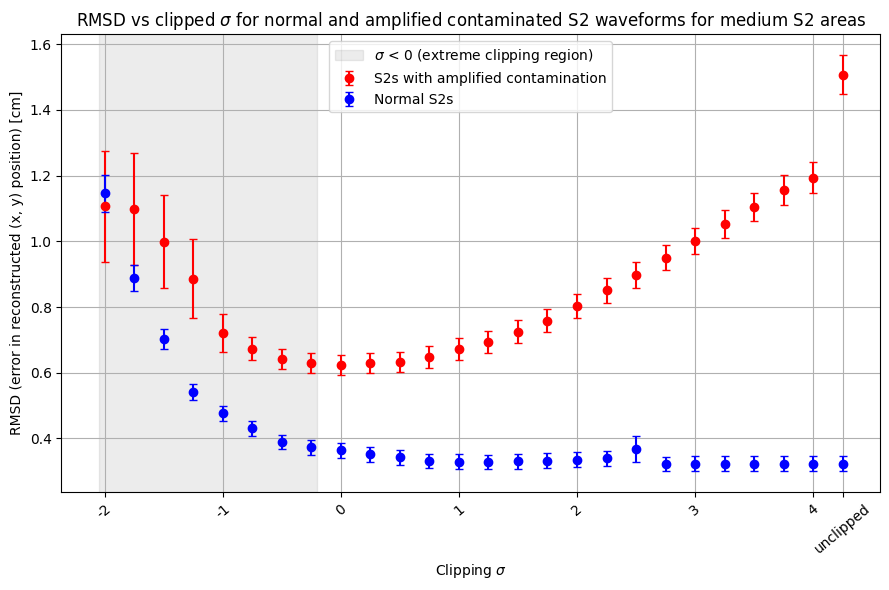

In [16]:
plt.figure(figsize=(9, 6))
plt.axvspan(-2.05, -0.20, color='gray', alpha=0.15, label=r"$\sigma$ < 0 (extreme clipping region)")
plt.title(r"RMSD vs clipped $\sigma$ for normal and amplified contaminated S2 waveforms for medium S2 areas")
filter_consistent_events(df_ap_med, color ='r', label="S2s with amplified contamination")
filter_consistent_events(df_noap_med, color ='b', label="Normal S2s")



/var/folders/kt/_rxy3sgj2130mxg7ztfp46880000gn/T/ipykernel_58149/2207891000.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmsd_df = df_final.groupby("sigma").apply(rmsd_with_sem).reset_index()
/var/folders/kt/_rxy3sgj2130mxg7ztfp46880000gn/T/ipykernel_58149/2207891000.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmsd_df = df_final.groupby("sigma").apply(rmsd_with_sem).reset_index()


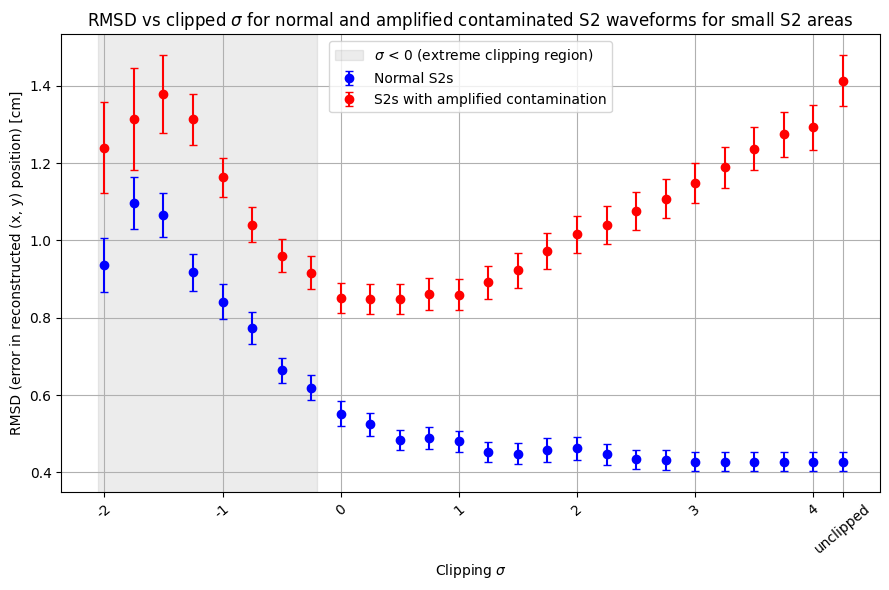

In [15]:
plt.figure(figsize=(9, 6))
plt.axvspan(-2.05, -0.20, color='gray', alpha=0.15, label=r"$\sigma$ < 0 (extreme clipping region)")
plt.title(r"RMSD vs clipped $\sigma$ for normal and amplified contaminated S2 waveforms for small S2 areas")
filter_consistent_events(df_noap, color ='b', label="Normal S2s")
filter_consistent_events(df_ap, color ='r', label="S2s with amplified contamination")


/var/folders/kt/_rxy3sgj2130mxg7ztfp46880000gn/T/ipykernel_58149/2207891000.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmsd_df = df_final.groupby("sigma").apply(rmsd_with_sem).reset_index()
/var/folders/kt/_rxy3sgj2130mxg7ztfp46880000gn/T/ipykernel_58149/2207891000.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmsd_df = df_final.groupby("sigma").apply(rmsd_with_sem).reset_index()


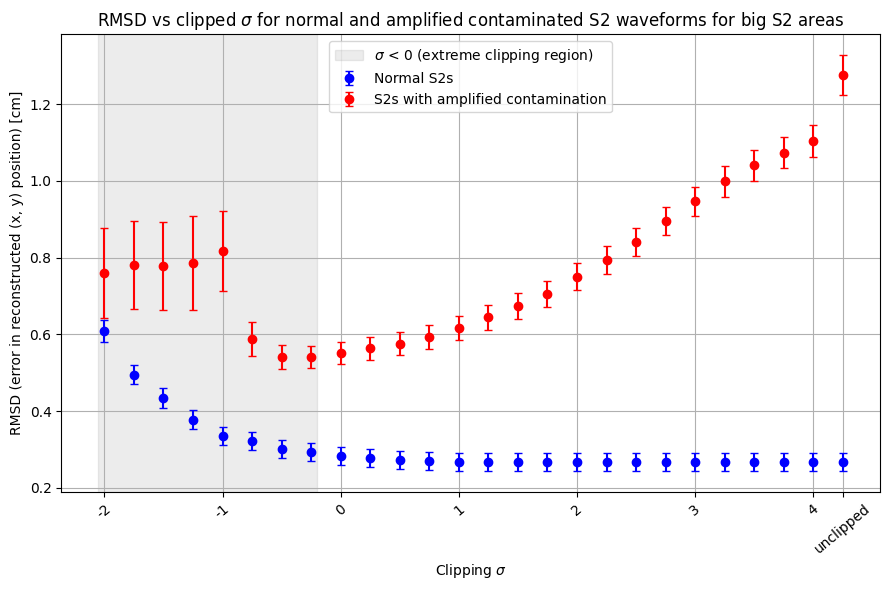

In [14]:
plt.figure(figsize=(9, 6))
plt.axvspan(-2.05, -0.20, color='gray', alpha=0.15, label=r"$\sigma$ < 0 (extreme clipping region)")
plt.title(r"RMSD vs clipped $\sigma$ for normal and amplified contaminated S2 waveforms for big S2 areas")
filter_consistent_events(df_noap_big, color ='b', label="Normal S2s")
filter_consistent_events(df_ap_big, color ='r', label="S2s with amplified contamination")

/var/folders/kt/_rxy3sgj2130mxg7ztfp46880000gn/T/ipykernel_58149/2207891000.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmsd_df = df_final.groupby("sigma").apply(rmsd_with_sem).reset_index()
/var/folders/kt/_rxy3sgj2130mxg7ztfp46880000gn/T/ipykernel_58149/2207891000.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmsd_df = df_final.groupby("sigma").apply(rmsd_with_sem).reset_index()
/var/folde

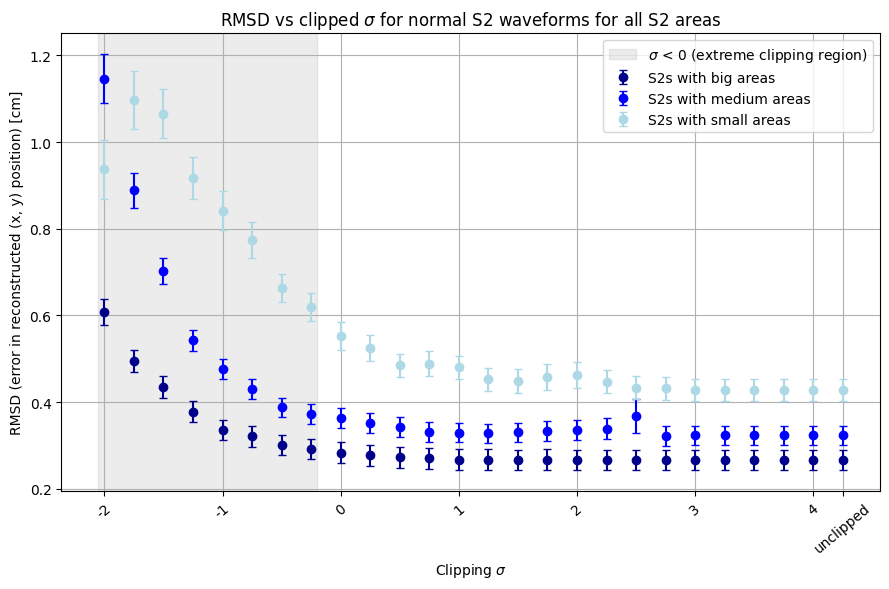

In [17]:
plt.figure(figsize=(9, 6))
plt.axvspan(-2.05, -0.20, color='gray', alpha=0.15, label=r"$\sigma$ < 0 (extreme clipping region)")
plt.title(r"RMSD vs clipped $\sigma$ for normal S2 waveforms for all S2 areas")
filter_consistent_events(df_noap_big, label="S2s with big areas", color="#00008B")
filter_consistent_events(df_noap_med, label="S2s with medium areas", color="blue")
filter_consistent_events(df_noap, label="S2s with small areas", color="#ADD8E6")

/var/folders/kt/_rxy3sgj2130mxg7ztfp46880000gn/T/ipykernel_58149/2207891000.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmsd_df = df_final.groupby("sigma").apply(rmsd_with_sem).reset_index()
/var/folders/kt/_rxy3sgj2130mxg7ztfp46880000gn/T/ipykernel_58149/2207891000.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmsd_df = df_final.groupby("sigma").apply(rmsd_with_sem).reset_index()
/var/folde

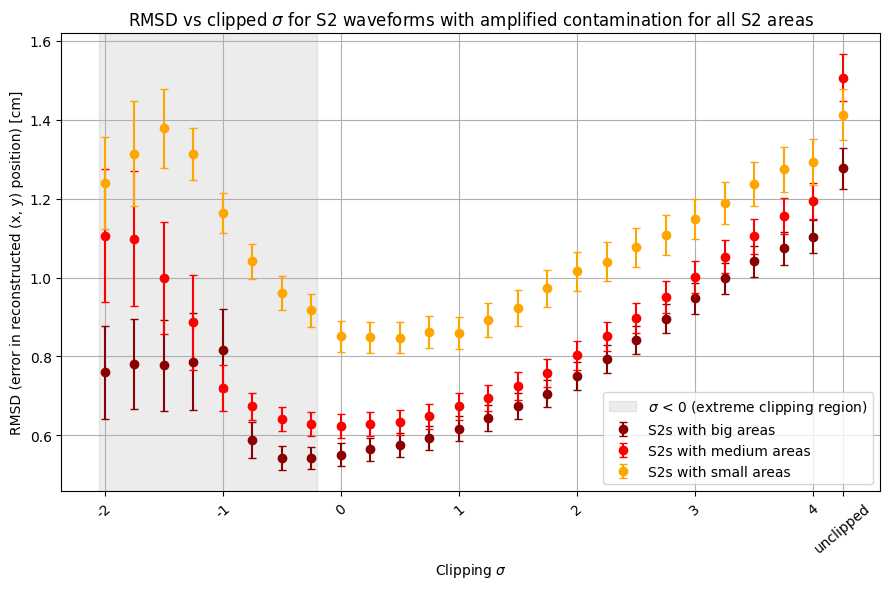

In [18]:
plt.figure(figsize=(9, 6))
plt.axvspan(-2.05, -0.20, color='gray', alpha=0.15, label=r"$\sigma$ < 0 (extreme clipping region)")
plt.title(r"RMSD vs clipped $\sigma$ for S2 waveforms with amplified contamination for all S2 areas")
filter_consistent_events(df_ap_big, label="S2s with big areas", color='#8B0000')
filter_consistent_events(df_ap_med, label="S2s with medium areas", color="r")
filter_consistent_events(df_ap, label="S2s with small areas", color="orange")



HIT PATTERN PLOTS (example)

In [7]:
#HITPATTERN PLOTTING FUNCTION
def hitpattern_plot_from_df(df, sigma, event_no, contamination, show=True):
    # Filter the rows matching this sigma
    df_sigma = df[df["sigma"] == sigma]

    # Reset index to access by position
    df_sigma = df_sigma.reset_index(drop=True)

    if event_no >= len(df_sigma):
        raise IndexError(f"Event {event_no} not found for sigma={sigma}")

    # Parse the area_per_channel string
    area_str = df_sigma.loc[event_no, "area_per_channel"]
    area_per_channel = np.array(list(map(float, area_str.split(','))))
    
    print(len(area_per_channel))

    # Get PMT positions (top only)
    pmt_pos = straxen.pmt_positions()
    top_mask = pmt_pos['array'] == 'top'
    pmt_pos_top = pmt_pos[top_mask]

    # Clip and select top
    area_top = area_per_channel[:len(pmt_pos_top)]
    area_top = np.clip(area_top, 1e-1, None)
    
    plt.figure(figsize=(8, 8))
    
    # Plotting
    vmax_global = df["area_per_channel"].map(lambda s: max(map(float, s.split(',')))).max()

    #norm = colors.LogNorm(vmin=1e-2, vmax=np.max(area_top))
    norm = colors.LogNorm(vmin=1e-1, vmax=vmax_global)

    sc = plt.scatter(pmt_pos_top['x'], pmt_pos_top['y'], c=area_top,
                     cmap='turbo', norm=norm, s=100)

    plt.colorbar(sc, label='Number of photoelectrons [PE]')
    

    plt.xlabel('x [cm]')
    plt.ylabel('y [cm]')
    if sigma == 4.25:
        plt.title(rf'Top PMT Hitpattern with {contamination}: Event {event_no}')
        #plt.title(rf'Hitpattern with {contamination}: Event {event_no}')
    else:
        plt.title(rf'Hitpattern with {contamination}: Event {event_no} - Clipped at {sigma}$\sigma$')
    plt.gca().set_aspect('equal')
    #plt.tricontour(pmt_pos_top['x'], pmt_pos_top['y'], area_top, levels=5, colors='black', linewidths=0.5)
    
    if show:
        x_obs = df_sigma.loc[event_no, "x_obs"]
        y_obs = df_sigma.loc[event_no, "y_obs"]
        x_mlp = df_sigma.loc[event_no, "x_mlp"]
        y_mlp = df_sigma.loc[event_no, "y_mlp"]

        plt.scatter(x_obs, y_obs, c="red", marker="x", s=100, label="x_obs (truth)")
        plt.scatter(x_mlp, y_mlp, c="blue", marker="x", s=100, label="x_mlp (reco)")
        plt.legend()
    plt.show()

494


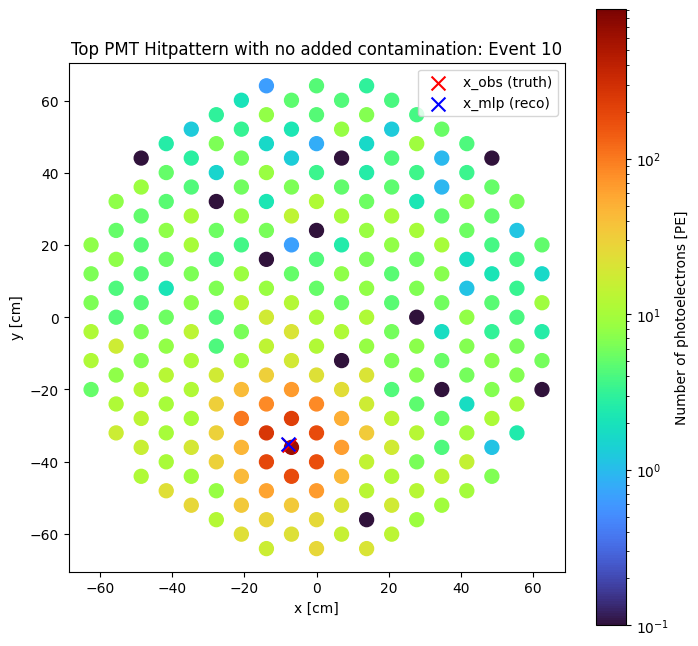

In [21]:
hitpattern_plot_from_df(df_noap, sigma=4.25, event_no=10, contamination='no added contamination', show=True)

EVENT WAVEFORM PLOTS

In [32]:
#PLOTTING EVENT WAVEFORMS
def plot_event_waveform(df, event_id, sigma, label=None, color='black', show_fit=False, **kwargs):
    row = df[
        (df['event_id'] == event_id) & 
        (df['sigma'] == sigma)
    ]

    if row.empty:
        raise ValueError(f"No entry found for event {event_id} at σ={sigma}")

    row = row.iloc[0]

    n = int(row["event_waveform_length"])
    t0 = row["event_basics"]
    dt = row["event_waveform_dt"]
    data = np.array([float(x) for x in row["event_waveform_data"].split(',')])

    #time = (np.arange(n) * dt)/1000
    time = (t0 + np.arange(n) * dt)/1000

    plt.plot(time, data[:n], drawstyle="steps-mid", label=label, color=color, **kwargs)
    plt.xlabel(rf"Time relative to S2 start [$\mu$s]")
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.1f}"))
    plt.ylabel(rf"Photoelectrons per bin [PE]")
    
    plt.grid(True)

    if label:
        plt.legend()
    if sigma == 4.25:
        plt.title(rf"S2 signals with amplified contamination for event {event_id}")
    else:   
        plt.title(rf"S2 signal: Event {event_id} Clipped at $\sigma$={sigma}")
    plt.tight_layout()


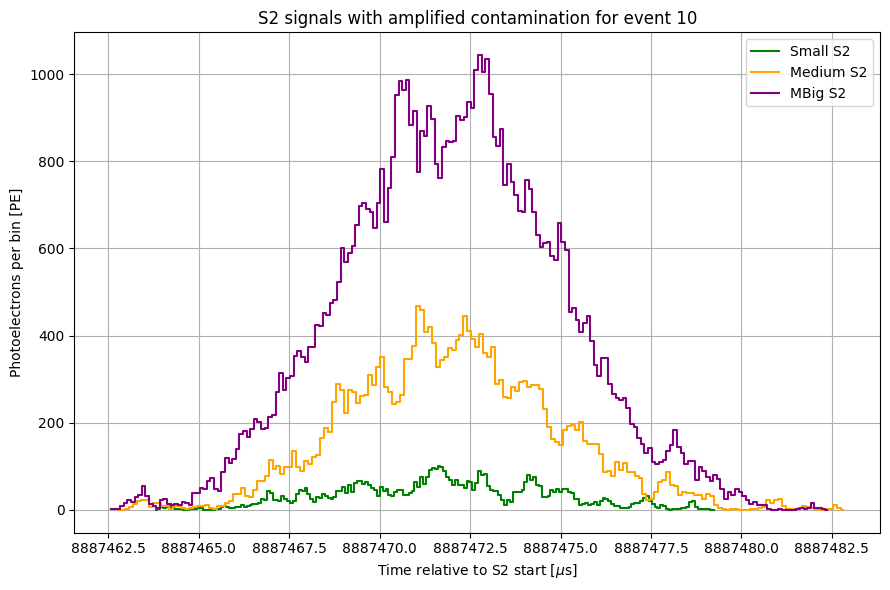

In [36]:
plot_event_id = 10
plot_sigma = 4.25

plt.figure(figsize=(9, 6))
plot_event_waveform(df_noap, event_id=plot_event_id, sigma=plot_sigma, label="Small S2", color='g')
plot_event_waveform(df_noap_med, event_id=plot_event_id, sigma=plot_sigma, label="Medium S2", color='orange')
plot_event_waveform(df_noap_big, event_id=plot_event_id, sigma=plot_sigma, label="MBig S2", color='purple')




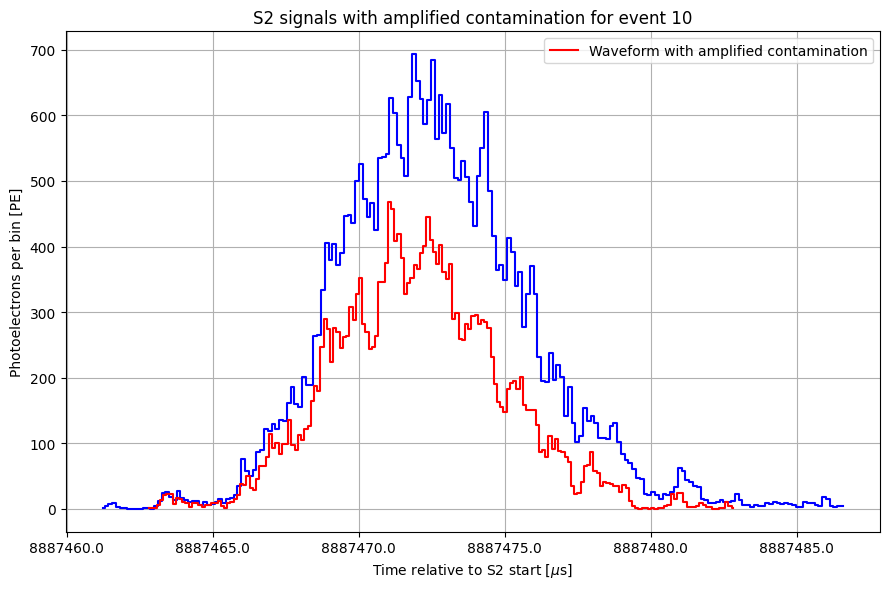

In [41]:
plt.figure(figsize=(9, 6))
plot_event_waveform(df_ap_med, event_id=plot_event_id, sigma=plot_sigma, color='b', show_fit=True)
plot_event_waveform(df_noap_med, event_id=plot_event_id, sigma=plot_sigma, label="Waveform with amplified contamination", color='r')